In [1]:
suppressMessages({
    require(Seurat)
    library(dplyr)
    library(ggtree)
    library(phangorn)
    library(cluster)
    library(ggplot2)
    library(hash)
    library(dendextend)
    library(ape)
})

PercentAbove <- function(x, threshold) { return(length(x = x[x > threshold]) / length(x = x)) }
get_pct_matrix <- function(object, vars, cells, group.by){
    data.features <- FetchData(object = object, vars = vars, cells = cells)
    data.features$id <- if (!is.null(x = group.by)) {
        object[[group.by, drop = TRUE]][cells, drop = TRUE]
    }
    
    res <- Reduce(rbind, lapply(X = unique(x = data.features$id), FUN = function(ident) {
        data.use <- data.features[data.features$id == ident, 1:(ncol(x = data.features) - 1), drop = FALSE]
        pct.exp <- apply(X = data.use, MARGIN = 2, FUN = PercentAbove, threshold = 0)
        return(pct.exp)
    }))
    rownames(res) <- unique(data.features$id)
    res <- t(res)
    return(res)
}

source("Trinarization_score.R")


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [2]:
tree <- read.tree('nwk/mouse.cerebellar_subnuclei.dend.nwk')
# we focus on region variant excitatory neurons rather than invariant inhibitory neurons
mouse <- readRDS('../1.update_atlas/GSM4873765_mouse_data.coding_genes.rds')
mouse@meta.data$cell_type <- factor(mouse@meta.data$cell_type, levels = labels(as.dendrogram(tree)))
markers <- read.table('../2.ohnolog_significance/1.markers/mouse.ex.DEGs.subnuclei_class.txt', header = T)
Idents(mouse)<-'cell_type'

In [3]:
TFs <- read.table('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/07.species_signals/6.TF_vs_species_signals/TFs/Mmus_TFs.name.txt')$V1

In [4]:
exp <- trinarize(mouse, 0.1, label = "cell_type")
binary_matrix <- exp
binary_matrix[binary_matrix < 0.05] = 0
binary_matrix[binary_matrix != 0] = 1

In [5]:
# markers might be influenced the number/quality of cells in each cluster,
# based on several testing, I used very strigent filtering to get more 'significant' markers for each cell type
#markers <- markers %>% filter(p_val_adj < 0.01 & avg_log2FC > 1 & pct.1 > 0.1 & (pct.1/(pct.2+0.01)) > 1.5)
#binary_matrix <- binary_matrix[unique(markers$gene), ]

In [6]:
#binary_matrix <- binary_matrix[rownames(binary_matrix) %in% TFs,]
dim(binary_matrix)

[1] 19190    11

In [7]:
#Mmus_pct <- get_pct_matrix(object = mouse, vars = unique(markers$gene), cells=colnames(mouse), group.by="cell_type")

In [8]:
# binarize gene matrix as 1 (marker) or 0 (not marker)
#binary_matrix <- Mmus_pct
#binary_matrix <- binary_matrix[rownames(binary_matrix) %in% unique(markers$gene), ]
#binary_matrix[,] <- 0
#
#for (i in unique(as.character(markers$cluster))){
#    binary_matrix[rownames(binary_matrix) %in% markers[markers$cluster == i, "gene"], i] <- 1
#}

In [9]:
# predict ancestral states for class A duplication
phyDat.binary <- phyDat(t(binary_matrix), type = "USER", levels = c(0,1))
anc.acctran <- ancestral.pars(tree, phyDat.binary, "ACCTRAN", return = "prob")
predicted <- matrix(NA, nrow = length(anc.acctran), ncol = nrow(binary_matrix))
tmp <- lapply(anc.acctran, FUN = function(x) { apply(x, 1, FUN = function(y) {
  if (1 %in% y){c(0,1)[which(y > 0.5)]} else {0}})}) # simple decision, prob > 0.5 is 1 
node_tip <- length(tree$tip.label) + tree$Nnode
anc.acctran.binary <- matrix(unlist(tmp), nrow = node_tip, byrow = T)
rownames(anc.acctran.binary) <- names(tmp)

In [10]:
tips <- tree$tip.label
inodes <- (length(tree$tip.label) + 2):(length(tree$tip.label) + tree$Nnode)

In [11]:
binary_matrix <- binary_matrix[,rownames(anc.acctran.binary)[1:length(tree$tip.label)]]
gain_loss <- hash()

for (i in c(inodes, tips)){
#for (i in c('Lat.A1')){
    if (!is.na(as.integer(i))){
        i <- as.integer(i)
    }
    anode <- getMRCA(tree, c(i,i)) # ancestral node
    anc <- anc.acctran.binary[anode, ] # binarized ancestral pattern
    # gain or loss pattern
    gain <- anc.acctran.binary[1:length(tree$tip.label), (anc.acctran.binary[i, ] - anc.acctran.binary[anode, ]) == 1, drop = FALSE]
    loss <- anc.acctran.binary[1:length(tree$tip.label), (anc.acctran.binary[i, ] - anc.acctran.binary[anode, ]) == -1, drop = FALSE]
    
    gains <- c()
    losses <- c()
    if (ncol(gain) >= 1){
        for (x in 1:ncol(gain)){
            pattern <- gain[,x]
            gains <- c(gains, names(apply(binary_matrix, 1, function(x) all(x == pattern)))[apply(binary_matrix, 1, function(x) all(x == pattern))])
        }
    }
    if (ncol(loss) >= 1){
        for (x in 1:ncol(loss)){
            pattern <- loss[,x]
            losses <- c(losses, names(apply(binary_matrix, 1, function(x) all(x == pattern)))[apply(binary_matrix, 1, function(x) all(x == pattern))])
        }
    }
    
    hash_i <- hash()
    hash_i[['gain']] <- if (is.null(gains)) NA else unique(gains)
    hash_i[['loss']] <- if (is.null(losses)) NA else unique(losses)
    i <- as.character(i)
    gain_loss[[i]] <- hash_i
}

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [12]:
for (key in keys(gain_loss)){
    for (i in c('gain','loss')){
        line <- paste(key, i, gain_loss[[key]][[i]], sep = "\t")
        write(line, file = 'Mmus.gain_loss.txt', append = TRUE)
    }
}

In [13]:
info <- hash()
for (i in c(inodes, tips)){
    tmp <- gain_loss[[i]][['gain']]
    n_gain <- length(tmp[!is.na(tmp)])
    n_gain_TFs <- sum(tmp[!is.na(tmp)] %in% TFs)
    tmp <- gain_loss[[i]][['loss']]
    n_loss <- length(tmp[!is.na(tmp)])
    n_loss_TFs <- sum(tmp[!is.na(tmp)] %in% TFs)
    text <- paste0('gain:', n_gain, ';', n_gain_TFs, '\nloss:', n_loss, ';', n_loss_TFs)
    
    if (!is.na(as.integer(i))){
        info[[i]] <- text
    } else {
        i = as.character(names(setNames(tips, 1:length(tips))[setNames(tips, 1:length(tips)) == i]))
        info[[i]] <- text 
    }
}

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [14]:
p = ggtree(tree, ladderize=F) + geom_tiplab() + ggtitle("ggtree")
edge=data.frame(tree$edge, edge_text= vapply(as.character(tree$edge[,2]), FUN = function(x){info[[x]]}, FUN.VALUE = character(1)) )
colnames(edge)=c("parent", "node", "edge_text")
p <- p %<+% edge + geom_label(aes(x=branch, label=edge_text)) + geom_text2(aes(subset = !isTip, label = node))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_label()`).”


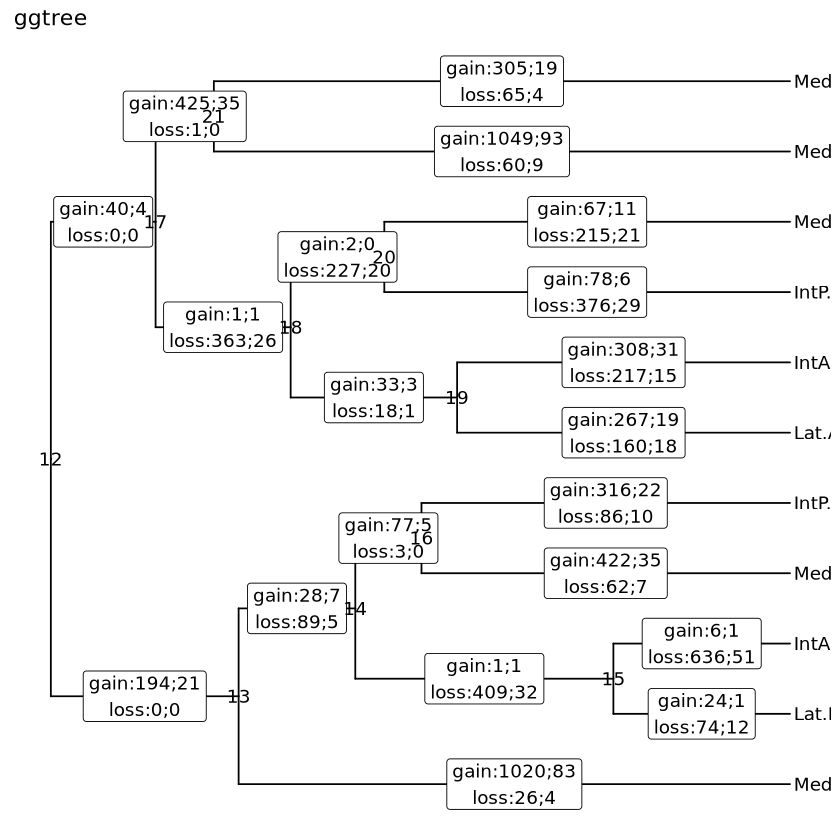

In [15]:
p
ggsave(filename = "results/mouse.cerebellar_nuclei.gene_gain_loss.pdf", p, width = 7, height = 7)

In [63]:
p1 <- DotPlot(mouse, features = c(
                         gain_loss[['Lat.A']][['gain']]
                        
                         #gain_loss[['Lat.A']][['loss']]
                        )) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

p2 <- DotPlot(mouse, features = c(
                         gain_loss[['Lat.B']][['gain']],
                         gain_loss[['Lat.B']][['loss']]
                        )) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

In [24]:
test <- FindMarkers(mouse, `ident.1` = "Lat.A", `ident.2` = "IntA.A")

In [27]:
test[rownames(test) %in% TFs & test$p_val_adj < 0.01,]

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
Esrrg 1.172659e-19 -1.0684217 1.000 1.000 2.250332e-15
Prox1 1.986243e-17 -4.4151648 0.049 0.509 3.811600e-13
Maf   7.329112e-12 -4.4455576 0.189 0.555 1.406457e-07
Meis2 1.251419e-08  0.9476402 0.958 0.800 2.401472e-04

In [30]:
test <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/13.case_analysis/1.cerebellum/6.SuppTables/SuppTable.cerebellar_subnuclei_markers_info.Mmus.txt')

In [23]:
gain_loss[['Lat.A']][['gain']][gain_loss[['Lat.A']][['gain']] %in% TFs]


[1] "Prdm14"        "Nr1h5"         "Zfp46"         "Gtf3a"        
 [5] "Spic"          "Nr1h4"         "Nmi"           "Pou1f1"       
 [9] "2310011J03Rik" "Gm6592"        "Zbtb7b"        "Gar1"         
[13] "Zfp513"        "Zfp963"        "Rfx5"          "Zfp324"       
[17] "Stat5a"        "Irx3"          "Mycn"

In [35]:
test[test$Gene_name %in% gain_loss[['Lat.B']][['loss']], ]

EnsemblID          Gene_name TFs   ohnologs family   
191  ENSMUSG00000015396 Cd83      FALSE FALSE             
313  ENSMUSG00000001504 Irx2       TRUE  TRUE    Irx5,Irx2
1160 ENSMUSG00000025582 Nptx1     FALSE FALSE

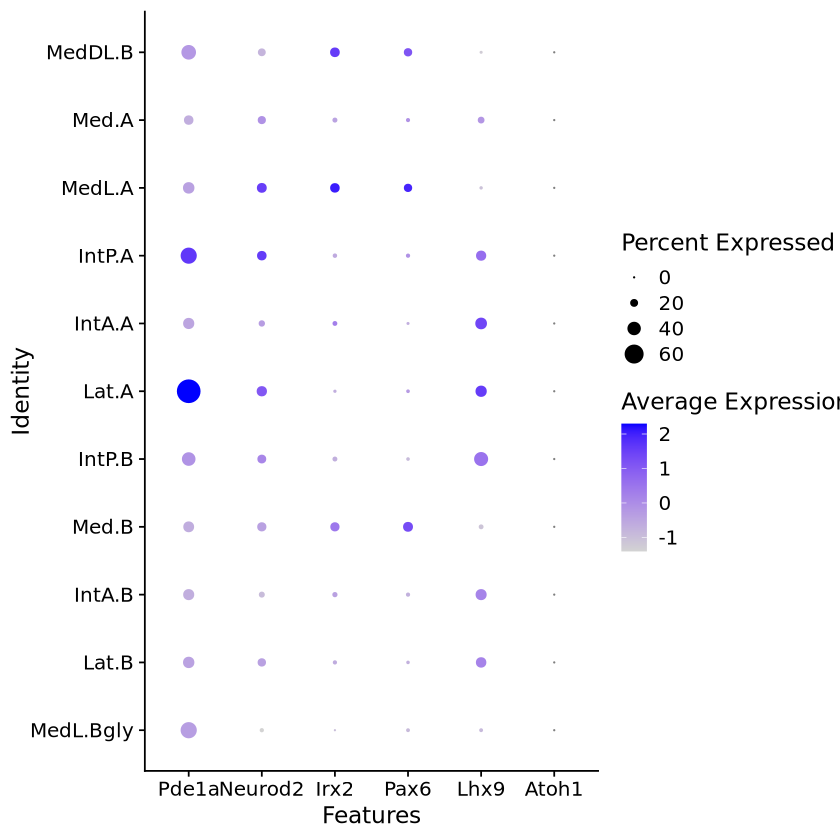

In [41]:
DotPlot(mouse, features = c('Pde1a', 'Neurod2', 'Irx2', 'Pax6', 'Lhx9', 'Atoh1'))

In [71]:
test[rownames(test) == 'Neurod2', ]

p_val       avg_log2FC pct.1 pct.2 p_val_adj
Neurod2 0.007139198 0.9513674  0.287 0.145 1

In [72]:
gain_loss[['Lat.A']][['loss']] %in% rownames(test)

[1]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

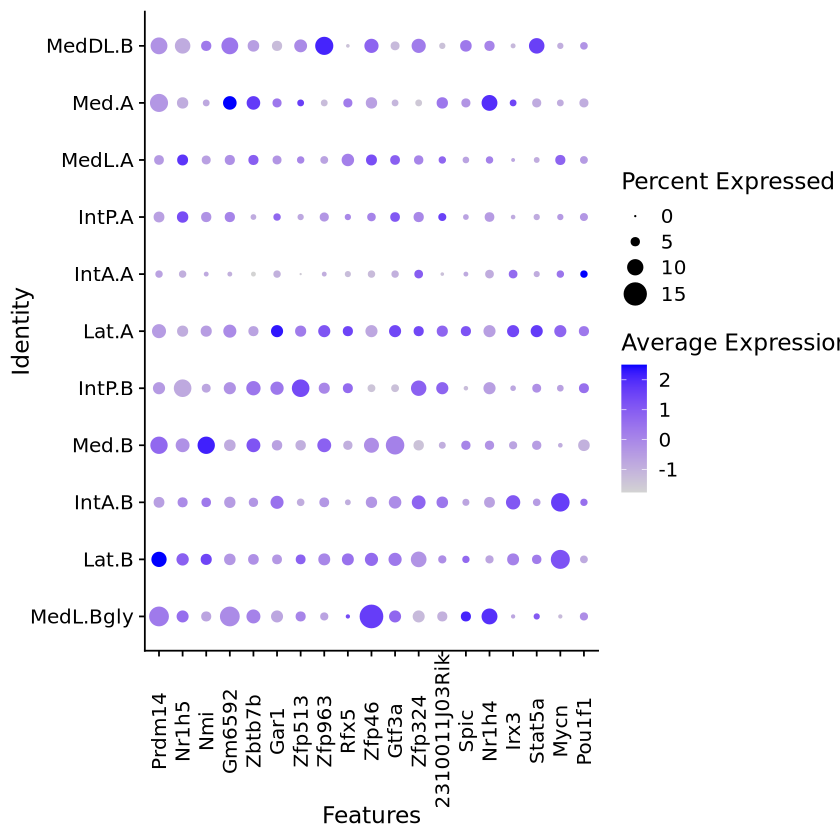

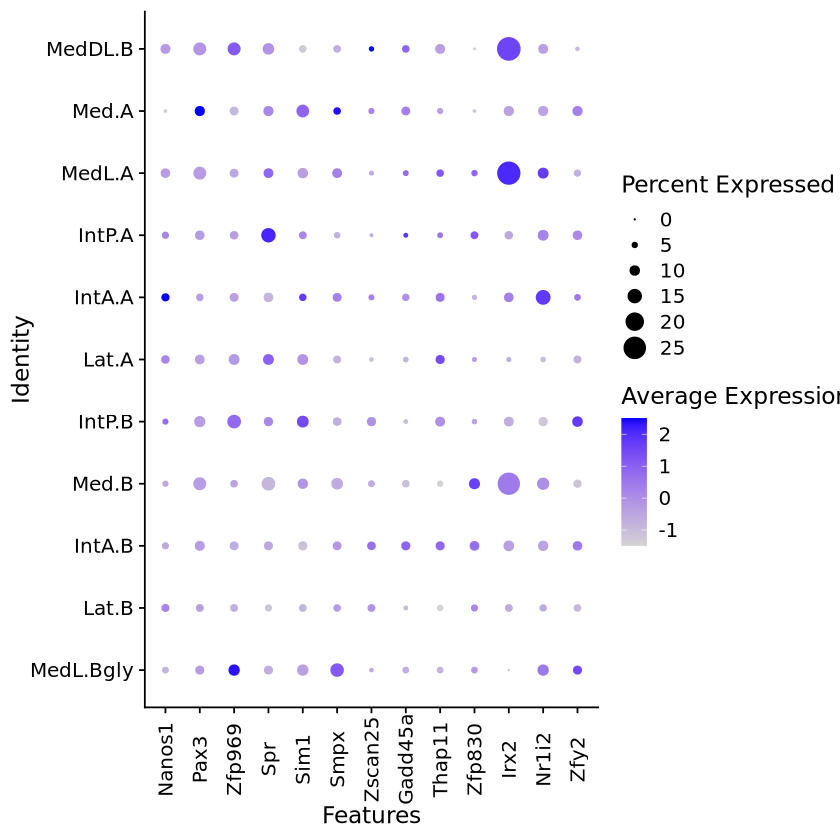

In [64]:
p1
p2

In [17]:
ggsave(filename = "results/Dotplot.mouse.Lat.A.mouse.pdf", p1, width = 10, height = 6)
ggsave(filename = "results/Dotplot.mouse.Lat.B.mouse.pdf", p2, width = 10, height = 6)

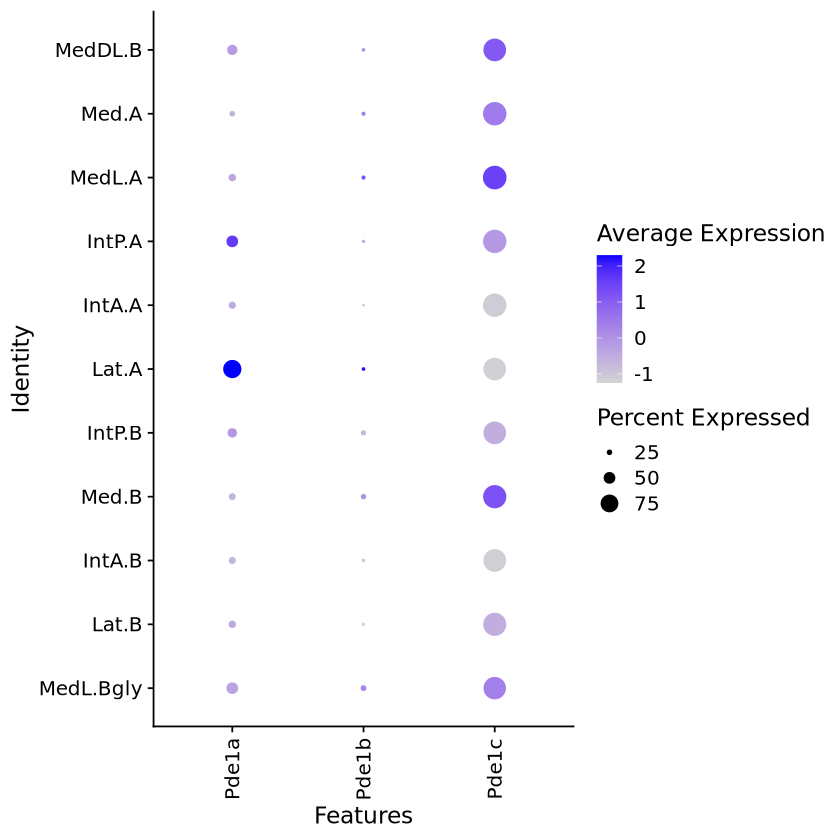

In [18]:
DotPlot(mouse, features = c('Pde1a', 'Pde1b', 'Pde1c')
       ) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

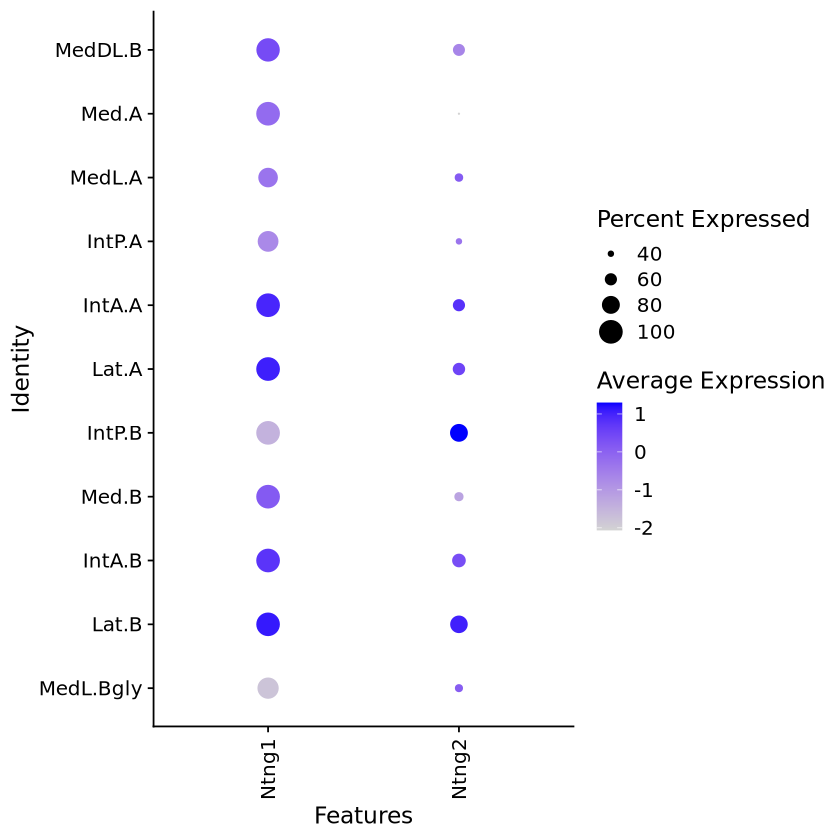

In [45]:
DotPlot(mouse, features = c('Ntng1','Ntng2')) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

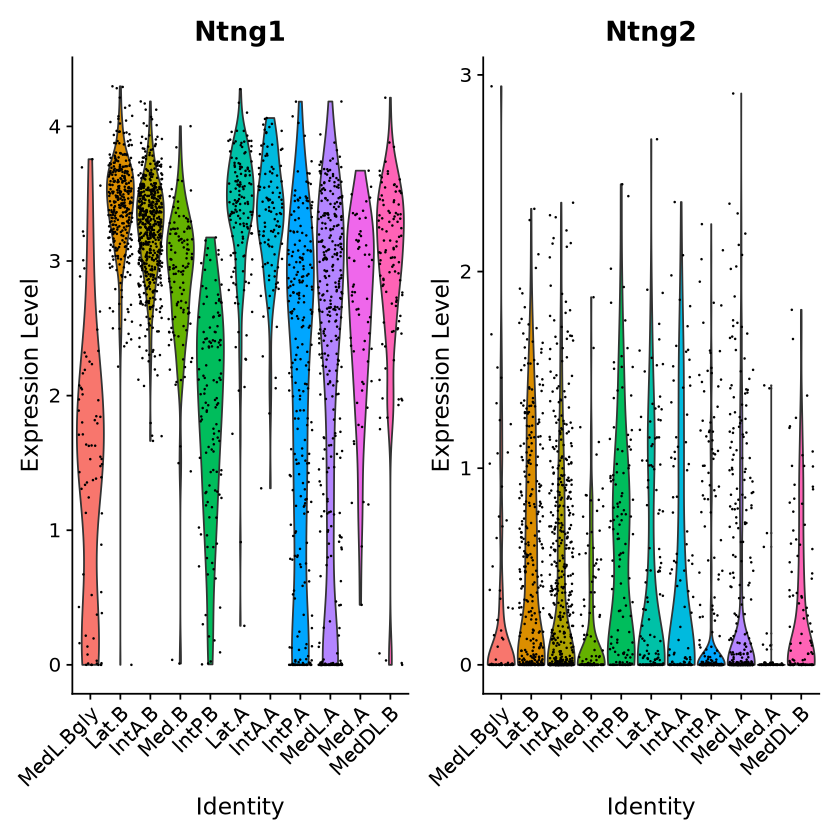

In [19]:
VlnPlot(mouse, features = c('Ntng1','Ntng2'))